### Rotten Tomatoes critics reviews analysis and film rating prediction with RNN and CNN

The below analysis aims to predict the rottentomatoes.com film ratings (Fresh or Rotten) using recurrent neural networks (RNN) and convolutional neural networks (CNN) and compare it with the results of machine learning analysis from the Film_data_analysis project.




In [1]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import keras.utils as ku 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional,Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import print_summary
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Conv2D,Conv1D,MaxPooling1D

In [4]:
np.warnings.filterwarnings('ignore')

In [5]:
import gensim
from gensim.models import KeyedVectors

In [6]:
import matplotlib.pyplot as plt

In [7]:
data=pd.read_csv('all_critic_opinions_movies4.csv')
data=data.drop('Unnamed: 0',axis=1)
data.sample(7)

,Title,Year,Review,TMeter,TMeter1
676,Alice in Wonderland,1951,Charm and relative simplicity play like a time...,0.79,1.0
2876,Dark Passage,1947,The structure and character sense of the David...,0.92,1.0
12699,The Truman Show,1998,Its unusually provocative and challenging for ...,0.94,1.0
8302,Pavilion,2013,"A lovely sonatina of a , brief and aching Mr S...",1.00,1.0
12124,The Pass,2016,An independent British production that manages...,0.93,1.0
6347,Le Petit Lieutenant,2006,"The results, while a bit overlong, are engagin...",0.78,1.0
13767,Watermarks,2005,"It is a treat to encounter the fierce, brave, ...",0.96,1.0


__Using the pretrained word2vec embedding from Wikipedia:__

In [8]:
w2v= gensim.models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec', binary=False)

embeddings = w2v.vectors
embeddings.shape

(999994, 300)

In [9]:
embeddings.shape[0] #nb of words for the model

999994

__Creating training and test sets:__

In [10]:
X=data.Review
y=data.TMeter1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape

((11462,), (2866,))

__Tokenizing words:__

In [13]:
tokenizer = Tokenizer(num_words=embeddings.shape[0])
tokenizer.fit_on_texts(X_train)

In [14]:
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

__Padding sequences:__

In [15]:
maxlen = 150 #max sequence length

In [16]:
X_train = sequence.pad_sequences(seq_train, maxlen=maxlen)
X_test = sequence.pad_sequences(seq_test, maxlen=maxlen)

__Categorizing predicted classes:__

In [17]:
pred_classes = 2 #predicting ratings Fresh or Rotten (1 or 0)

In [18]:
y_train = np_utils.to_categorical(y_train, pred_classes)
y_test = np_utils.to_categorical(y_test, pred_classes)

__Embeddig layer:__

In [19]:
embedding = Embedding(embeddings.shape[0],embeddings.shape[1],weights=[embeddings],trainable=False)

__Creating neural network model using SimpleRNN:__

In [20]:
model = Sequential()
model.add(embedding)
model.add(SimpleRNN(150, return_sequences=False))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         299998200 
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 150)               67650     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 302       
Total params: 300,066,152
Trainable params: 67,952
Non-trainable params: 299,998,200
_________________________________________________________________


In [21]:
early_stopping = EarlyStopping(patience=5)

history=model.fit(X_train, y_train, epochs=20, callbacks=[early_stopping], validation_split=0.15, batch_size=32)

Train on 9742 samples, validate on 1720 samples
Epoch 1/20
9742/9742 [==============================] - 12s 1ms/step - loss: 0.6692 - acc: 0.6141 - val_loss: 0.6646 - val_acc: 0.6134
Epoch 2/20
9742/9742 [==============================] - 12s 1ms/step - loss: 0.6580 - acc: 0.6222 - val_loss: 0.6662 - val_acc: 0.6099
Epoch 3/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6501 - acc: 0.6327 - val_loss: 0.6715 - val_acc: 0.6172
Epoch 4/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6415 - acc: 0.6396 - val_loss: 0.6782 - val_acc: 0.6067
Epoch 5/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6399 - acc: 0.6413 - val_loss: 0.6850 - val_acc: 0.5910
Epoch 6/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6376 - acc: 0.6411 - val_loss: 0.6756 - val_acc: 0.5951


In [22]:
model.evaluate(X_test, y_test, verbose=0)

[0.6830568711240227, 0.5867062109130625]

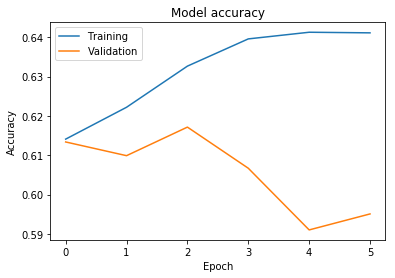

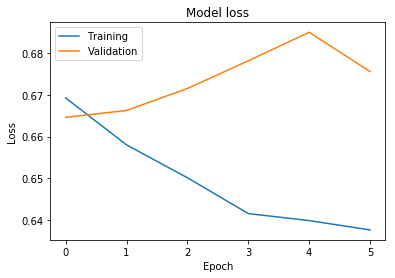

In [23]:
def PlotHistory(history):

    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
PlotHistory(history)

__Testing the model with the softmax activation function and regularization:__

In [26]:
model = Sequential()
model.add(embedding)
model.add(SimpleRNN(150, return_sequences=False,kernel_regularizer=l2(0.003)))
model.add(Dense(2, activation='softmax',kernel_regularizer=l2(0.003)))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         299998200 
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 150)               67650     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 300,066,152
Trainable params: 67,952
Non-trainable params: 299,998,200
_________________________________________________________________


In [27]:
early_stopping = EarlyStopping(patience=5)

history=model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=[early_stopping], validation_split=0.15)

Train on 9742 samples, validate on 1720 samples
Epoch 1/20
9742/9742 [==============================] - 12s 1ms/step - loss: 0.9547 - acc: 0.6051 - val_loss: 0.7612 - val_acc: 0.5988
Epoch 2/20
9742/9742 [==============================] - 12s 1ms/step - loss: 0.7145 - acc: 0.6133 - val_loss: 0.7058 - val_acc: 0.6186
Epoch 3/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6905 - acc: 0.6194 - val_loss: 0.7072 - val_acc: 0.6186
Epoch 4/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6874 - acc: 0.6205 - val_loss: 0.6891 - val_acc: 0.6169
Epoch 5/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.7042 - acc: 0.5930 - val_loss: 0.6790 - val_acc: 0.6192
Epoch 6/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6778 - acc: 0.6202 - val_loss: 0.6757 - val_acc: 0.6186
Epoch 7/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6757 - acc: 0.6174 - val_loss: 0.7328 - val_acc: 0.3814
Epoch 8

In [28]:
model.evaluate(X_test, y_test, verbose=0)

[0.7058652805350331, 0.6099092813945698]

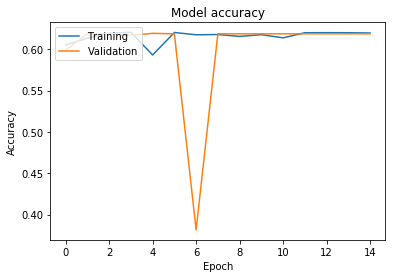

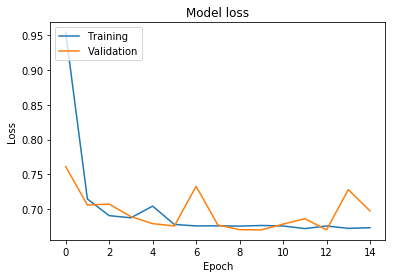

In [29]:
PlotHistory(history)

__Creating neural network model using LSTM:__

In [30]:
model = Sequential()
model.add(embedding)
model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5,kernel_regularizer=l2(0.003)))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         299998200 
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 300,218,106
Trainable params: 219,906
Non-trainable params: 299,998,200
_________________________________________________________________


In [31]:
early_stopping = EarlyStopping(patience=5)

history=model.fit(X_train, y_train, epochs=20, callbacks=[early_stopping], validation_split=0.15,batch_size=32)

Train on 9742 samples, validate on 1720 samples
Epoch 1/20
9742/9742 [==============================] - 29s 3ms/step - loss: 0.8035 - acc: 0.6172 - val_loss: 0.6791 - val_acc: 0.6186
Epoch 2/20
9742/9742 [==============================] - 31s 3ms/step - loss: 0.6742 - acc: 0.6210 - val_loss: 0.6721 - val_acc: 0.6186
Epoch 3/20
9742/9742 [==============================] - 31s 3ms/step - loss: 0.6720 - acc: 0.6193 - val_loss: 0.6714 - val_acc: 0.6186
Epoch 4/20
9742/9742 [==============================] - 32s 3ms/step - loss: 0.6695 - acc: 0.6195 - val_loss: 0.6760 - val_acc: 0.6145
Epoch 5/20
9742/9742 [==============================] - 31s 3ms/step - loss: 0.6699 - acc: 0.6195 - val_loss: 0.6719 - val_acc: 0.6186
Epoch 6/20
9742/9742 [==============================] - 30s 3ms/step - loss: 0.6694 - acc: 0.6201 - val_loss: 0.6695 - val_acc: 0.6186
Epoch 7/20
9742/9742 [==============================] - 30s 3ms/step - loss: 0.6688 - acc: 0.6194 - val_loss: 0.6736 - val_acc: 0.6186
Epoch 8

In [32]:
model.evaluate(X_test, y_test, verbose=0)

[0.6744632629023842, 0.6099092813945698]

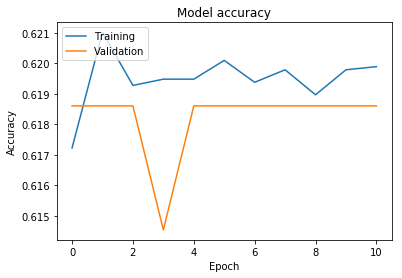

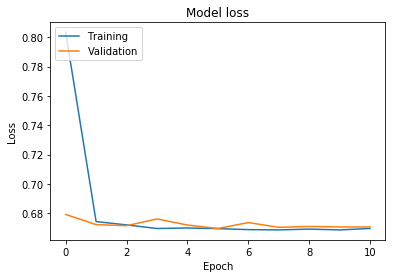

In [33]:
PlotHistory(history)

In [36]:
model = Sequential()
model.add(embedding)
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.5, dropout=0.5,kernel_regularizer=l2(0.003))))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         299998200 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 300,438,010
Trainable params: 439,810
Non-trainable params: 299,998,200
_________________________________________________________________


In [37]:
early_stopping = EarlyStopping(patience=5)

history=model.fit(X_train, y_train, epochs=20, callbacks=[early_stopping], validation_split=0.15,batch_size=32)

Train on 9742 samples, validate on 1720 samples
Epoch 1/20
9742/9742 [==============================] - 82s 8ms/step - loss: 0.9151 - acc: 0.6171 - val_loss: 0.6851 - val_acc: 0.6186
Epoch 2/20
9742/9742 [==============================] - 84s 9ms/step - loss: 0.6779 - acc: 0.6184 - val_loss: 0.6744 - val_acc: 0.6186
Epoch 3/20
9742/9742 [==============================] - 85s 9ms/step - loss: 0.6733 - acc: 0.6200 - val_loss: 0.6723 - val_acc: 0.6186
Epoch 4/20
9742/9742 [==============================] - 85s 9ms/step - loss: 0.6722 - acc: 0.6197 - val_loss: 0.6722 - val_acc: 0.6186
Epoch 5/20
9742/9742 [==============================] - 85s 9ms/step - loss: 0.6717 - acc: 0.6197 - val_loss: 0.6716 - val_acc: 0.6186
Epoch 6/20
9742/9742 [==============================] - 84s 9ms/step - loss: 0.6708 - acc: 0.6199 - val_loss: 0.6716 - val_acc: 0.6186
Epoch 7/20
9742/9742 [==============================] - 85s 9ms/step - loss: 0.6714 - acc: 0.6202 - val_loss: 0.6718 - val_acc: 0.6186
Epoch 8

In [38]:
model.evaluate(X_test, y_test, verbose=0)

[0.6765811258650125, 0.6099092813945698]

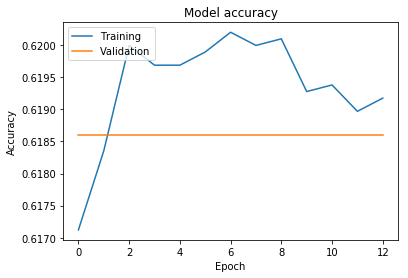

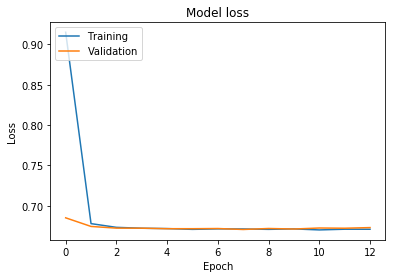

In [39]:
PlotHistory(history)

__Analysis with colvolutional neural network CNN:__

In [40]:
data1=pd.read_csv('data_no_token.csv')
data1=data1.drop('Unnamed: 0',axis=1)
data1.sample(7)

,Title,Year,Review,TMeter,TMeter1
302,A Good American,2017,intrigu troubl slow quiet infuri shock essenti...,0.90,1.0
13580,Veere Di Wedding,2018,make uniqu prospect pack perform led four ladi...,0.71,1.0
12839,The Widowmaker,2015,commend although work advocaci give array opin...,1.00,1.0
10240,Sweet November,2001,kept pray pacino would turn mere nightmar fois...,0.15,0.0
3736,Evilspeak,1982,may provid laugh two easili notic there much h...,0.43,0.0
2132,CBGB,2013,rush chaotic almost incoher recap backstori be...,0.08,0.0
3349,Downloading Nancy,2008,tortuous pain confus contriv enough put viewer...,0.16,0.0


__Training and testing data preparation:__

In [41]:
X=data1.Review
y=data1.TMeter1

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
tokenizer = Tokenizer(num_words=embeddings.shape[0])
tokenizer.fit_on_texts(X_train)

In [44]:
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

In [45]:
X_train = sequence.pad_sequences(seq_train, maxlen=maxlen)
X_test = sequence.pad_sequences(seq_test, maxlen=maxlen)

In [46]:
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [49]:
model_conv = Sequential()
model_conv.add(embedding)
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(2, activation='softmax'))

model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         299998200 
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 300,160,466
Trainable params: 162,266
Non-trainable params: 299,998,200
________________________________________________________

In [50]:
early_stopping = EarlyStopping(patience=5)

history=model_conv.fit(X_train, y_train, epochs=20, callbacks=[early_stopping], validation_split=0.15,batch_size=32, shuffle=True)

Train on 9742 samples, validate on 1720 samples
Epoch 1/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6626 - acc: 0.6203 - val_loss: 0.6550 - val_acc: 0.6186
Epoch 2/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.6164 - acc: 0.6598 - val_loss: 0.5760 - val_acc: 0.6878
Epoch 3/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.5054 - acc: 0.7504 - val_loss: 0.5544 - val_acc: 0.7081
Epoch 4/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.3854 - acc: 0.8294 - val_loss: 0.5724 - val_acc: 0.6977
Epoch 5/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.2478 - acc: 0.8982 - val_loss: 0.6222 - val_acc: 0.6965
Epoch 6/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.1653 - acc: 0.9348 - val_loss: 0.7457 - val_acc: 0.7203
Epoch 7/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.1190 - acc: 0.9551 - val_loss: 0.7651 - val_acc: 0.6948
Epoch 8

In [51]:
model_conv.evaluate(X_test, y_test, verbose=0)

[0.8844542215316343, 0.7236566643821386]

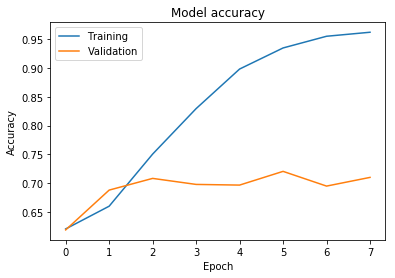

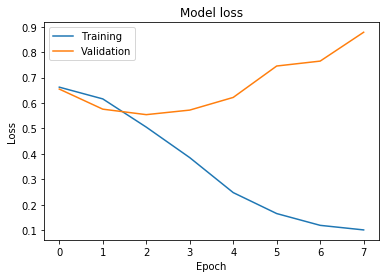

In [52]:
PlotHistory(history)

__Adding regularization parameters to lower the overfitting:__

In [57]:
model_conv = Sequential()
model_conv.add(embedding)
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100,kernel_regularizer=l2(0.003)))
model_conv.add(Dense(2, activation='softmax',kernel_regularizer=l2(0.003)))

model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         299998200 
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 300,160,466
Trainable params: 162,266
Non-trainable params: 299,998,200
________________________________________________________

In [58]:
early_stopping = EarlyStopping(patience=5)

history=model_conv.fit(X_train, y_train, epochs=20, callbacks=[early_stopping], validation_split=0.15,batch_size=32, shuffle=True)

Train on 9742 samples, validate on 1720 samples
Epoch 1/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.7397 - acc: 0.6159 - val_loss: 0.6811 - val_acc: 0.6186
Epoch 2/20
9742/9742 [==============================] - 15s 2ms/step - loss: 0.6680 - acc: 0.6207 - val_loss: 0.6627 - val_acc: 0.6267
Epoch 3/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.6443 - acc: 0.6423 - val_loss: 0.6085 - val_acc: 0.6564
Epoch 4/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.6141 - acc: 0.6635 - val_loss: 0.6116 - val_acc: 0.6826
Epoch 5/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.5803 - acc: 0.7013 - val_loss: 0.6060 - val_acc: 0.7099
Epoch 6/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.5507 - acc: 0.7316 - val_loss: 0.5344 - val_acc: 0.7349
Epoch 7/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.5332 - acc: 0.7396 - val_loss: 0.5426 - val_acc: 0.7436
Epoch 8

In [59]:
model_conv.evaluate(X_test, y_test, verbose=0)

[0.5267729899181158, 0.747034194081793]

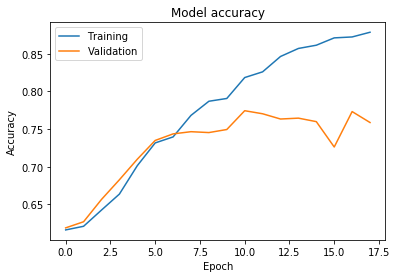

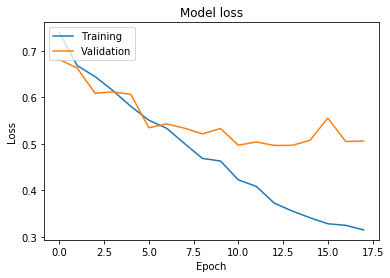

In [60]:
PlotHistory(history)

__Trying the model with different activation functions:__

In [66]:
model_conv = Sequential()
model_conv.add(embedding)
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(64, 5, activation='tanh'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100,kernel_regularizer=l2(0.003)))
model_conv.add(Dense(2, activation='sigmoid',kernel_regularizer=l2(0.003)))

model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         299998200 
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 300,160,466
Trainable params: 162,266
Non-trainable params: 299,998,200
________________________________________________________

In [67]:
early_stopping = EarlyStopping(patience=5)

history=model_conv.fit(X_train, y_train, epochs=20, callbacks=[early_stopping], validation_split=0.15,batch_size=32, shuffle=True)

Train on 9742 samples, validate on 1720 samples
Epoch 1/20
9742/9742 [==============================] - 14s 1ms/step - loss: 0.7222 - acc: 0.6194 - val_loss: 0.6730 - val_acc: 0.6186
Epoch 2/20
9742/9742 [==============================] - 15s 2ms/step - loss: 0.6651 - acc: 0.6206 - val_loss: 0.6609 - val_acc: 0.6201
Epoch 3/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.6405 - acc: 0.6412 - val_loss: 0.6707 - val_acc: 0.5892
Epoch 4/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.6179 - acc: 0.6681 - val_loss: 0.6210 - val_acc: 0.6590
Epoch 5/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.5986 - acc: 0.6842 - val_loss: 0.5989 - val_acc: 0.7081
Epoch 6/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.5841 - acc: 0.7017 - val_loss: 0.5500 - val_acc: 0.7224
Epoch 7/20
9742/9742 [==============================] - 16s 2ms/step - loss: 0.5696 - acc: 0.7062 - val_loss: 0.5730 - val_acc: 0.7160
Epoch 8

In [68]:
model_conv.evaluate(X_test, y_test, verbose=0)

[0.5455921842389729, 0.7416259595670653]

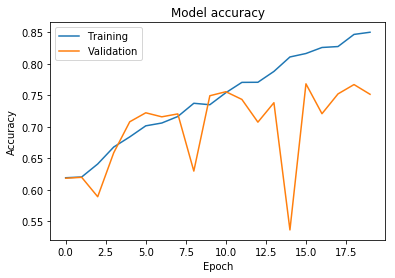

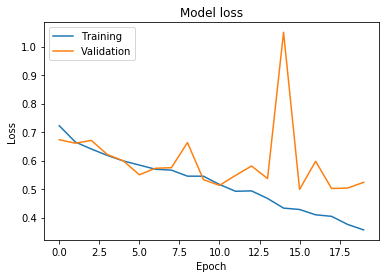

In [69]:
PlotHistory(history)

## Conclusions
__Best results with RNN analysis: approx. 60% accuracy on the test set.__
__Best results with CNN analysis: approx. 74% accuracy on the test set.__
__For this particualr data set the Logistic Regression model seems to give the best results: approx. 86% accuracy on the test set.__
